# Проект 6 - Procrastinate Pro+

## Введение

**Описание проекта**

Несколько прошлых месяцев бизнес Procrastinate Pro+ постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Описание данных**

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

1. `User Id` — уникальный идентификатор пользователя
2. `Device` — категория устройства пользователя
3. `Session start` — дата и время начала сессии
4. `Session End` — дата и время окончания сессии
5. `Channel` — идентификатор рекламного источника, из которого пришел пользователь
6. `Region` - страна пользователя

Таблица `orders_log_short` (информация о заказах):

1. `User Id` — уникальный id пользователя, который сделал заказ
2. `Event Dt` — дата и время покупки
3. `Revenue` — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

1. `Channel` — идентификатор рекламного источника
2. `Dt` — дата
3. `Costs` — затраты на этот рекламный источник в этот день

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them.
try:
    raw_visits = pd.read_csv('visits_info_short.csv')
    raw_orders = pd.read_csv('orders_info_short.csv')
    raw_costs = pd.read_csv('costs_info_short.csv')
except:
    raw_visits = pd.read_csv('/datasets/visits_info_short.csv')
    raw_orders = pd.read_csv('/datasets/orders_info_short.csv')
    raw_costs = pd.read_csv('/datasets/costs_info_short.csv')
    
# Constants, which we will need later.
FIG_WIDTH = 10
FIG_HEIGHT = 6
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)
OBSERVATION_DATE = datetime(2019, 11, 1)
HORIZON_DAYS = 14

In [38]:
# Let's have a look what is inside.
for data_frame in [raw_visits, raw_orders, raw_costs]:
    display(data_frame.head(3))
    raw_visits.info()
    print(50 * '-')

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
--------------------------------------------------


Очень красивые таблицы. Причешем их немного.

In [39]:
# Datasets, which we will clean up.
df_visits, df_orders, df_costs = raw_visits.copy(), raw_orders.copy(), raw_costs.copy()

# Snake case for column names, no spaces. 
for data_frame in [df_visits, df_orders, df_costs]:
    data_frame.columns = data_frame.columns.str.lower()
    data_frame.columns = data_frame.columns.str.replace(' ', '_')
    
# Set data types.
df_visits = df_visits.astype({'user_id': 'object',
                              'region': 'object',
                              'device': 'object',
                              'channel': 'object',
                              'session_start': 'datetime64[D]',
                              'session_end': 'datetime64[D]'})

df_orders = df_orders.astype({'user_id': 'object',
                              'event_dt': 'datetime64[D]',
                              'revenue': 'float64'})

df_costs = df_costs.astype({'dt': 'datetime64[D]',
                            'channel': 'object',
                            'costs': 'float64'})

Скорей всего, нам достались нормальные данные без аномалий. Но из большого любопытства проверим.

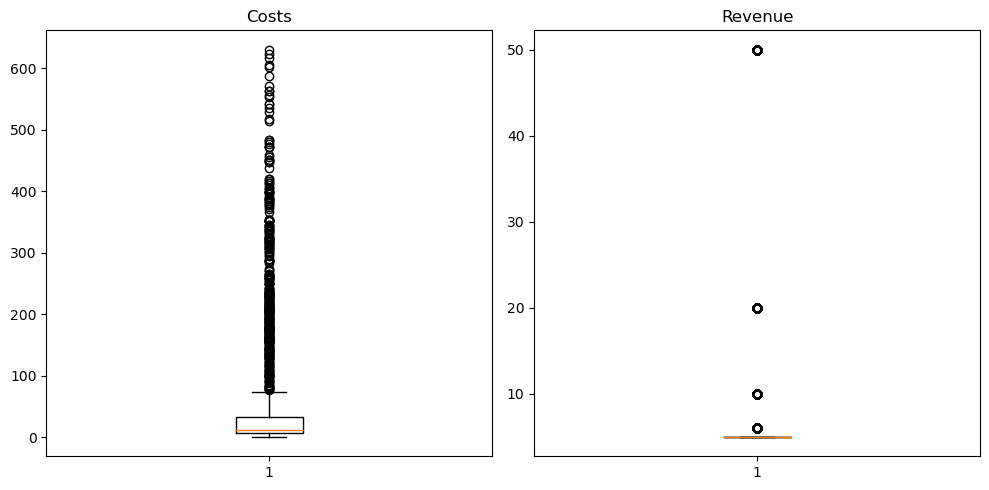

In [40]:
# Boxplots first.
def fun_get_boxplots_for_columns(columns: list,
                                 titles: list,
                                 num_rows: int,
                                 num_columns: int):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        columns (List): list of columns to plot from a DataFrame.
        
        titles (List): list of titles for subplots.
        
        num_rows (int): number of rows in subplots.
        
        num_columns (int): number of columns in subplots.
    """
    # Create subplots.
    fig, axs = plt.subplots(num_rows, num_columns, figsize=FIG_SIZE)

    # Popuplate subplots.
    for i, ax in enumerate(axs.flat):
        ax.boxplot(columns[i].dropna())
        ax.set_title(titles[i])

    plt.tight_layout()

fun_get_boxplots_for_columns([df_costs.costs, df_orders.revenue],
                             ['Costs', 'Revenue'],
                             1, 2)

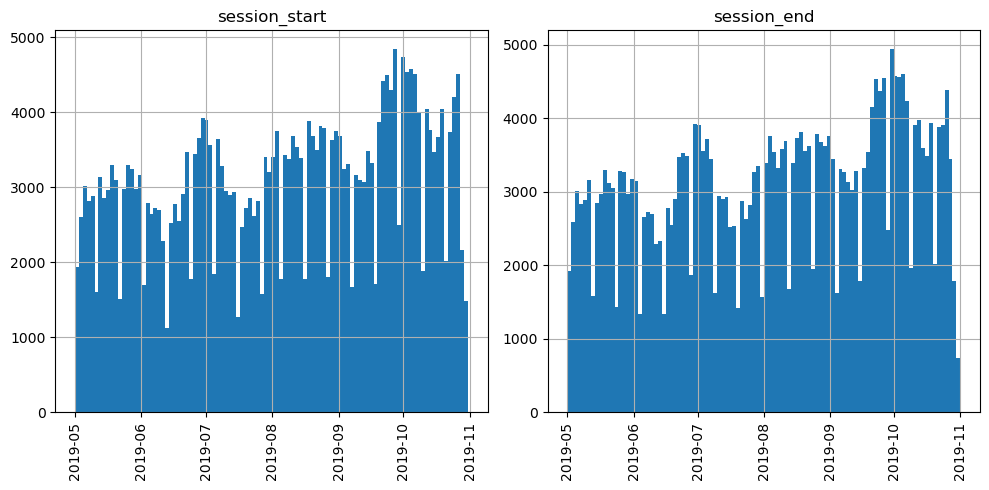

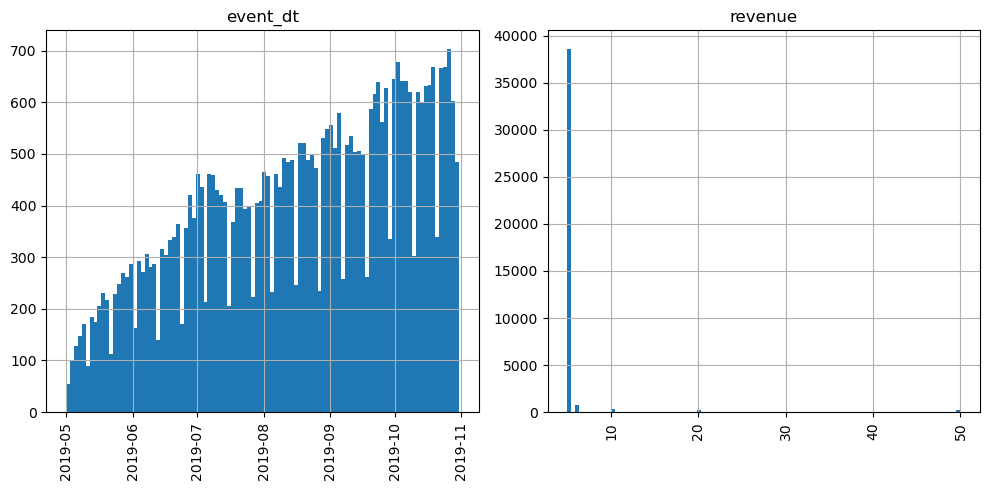

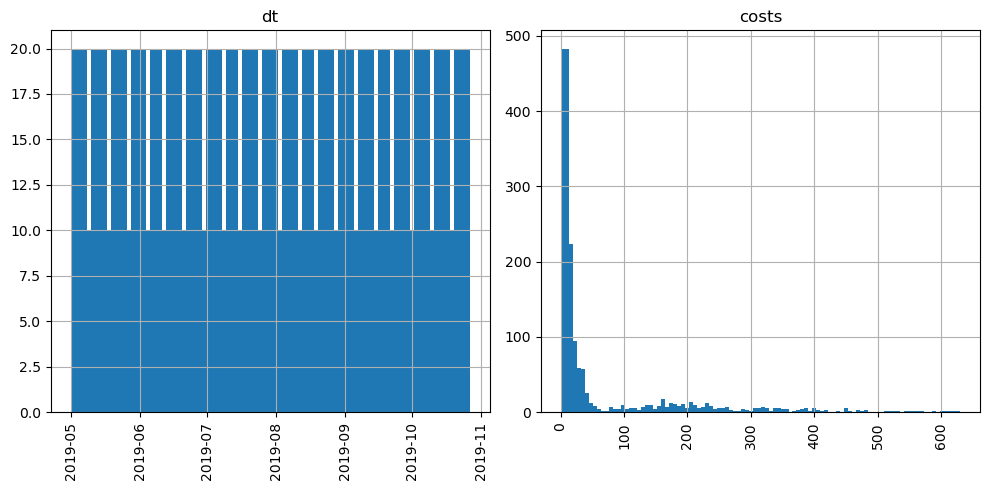

In [41]:
# Histograms.
for data_frame in [df_visits, df_orders, df_costs]:
    data_frame.hist(bins=100,
                    figsize=FIG_SIZE,
                    xrot=90)
    plt.tight_layout()

Любопытство нас не подвело. Несколько наблюдений: во-первых, частота визитов и заказов растет - это видно по гистрограммам сессий и дат заказов. Во-вторых, что-то интересное происходит с нашей выручной и издержками - у нас есть выборосы в первом случае и странный хвост во втором.

Оставим цифры в покое, т.к. пока непонятно, что делать с этими хвостами. Но будем держать в уме такие аномалии - возможно, они создадут нам проблемы в ходе анализа.

## Функции для расчетов

Во время наших приключений нам придется работать с несколькими функциями. Объявим их заранее и немного приведем в порядок.

In [42]:
# User profiles.
def fun_get_profiles(sessions: pd.DataFrame,
                     orders: pd.DataFrame,
                     costs: pd.DataFrame) -> pd.DataFrame:
    """
    This function returns a dataframe of customer profiles from three input dataframes.
    1. For each unique user the function identifies what was the first time, channel, device and region recorded.
    2. Then it adds a 'payer' flag if a user have placed and order before.
    3. Then it calculates number of people in a cohort (assuming a cohort is unique for a first interaction date and channel).
    4. Then for each cohort it pulls ad costs and calculates acquisition cost per unique user.
    5. Finally, all previous steps are merged into a single dataframe of customer profiles.

    Args:
        sessions (DataFrame): each row is a record of site interactions by a unique user.
        Has to have columns 'user_id', 'region', 'device', 'channel', 'session_start', 'session_end'.
        
        orders (DataFrame): each row is a purchase by a unique user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        costs (DataFrame): each row is a money spent on a channel per day.
        Has to have columns 'user_id', 'event_dt', 'revenue'.

    Returns:
        profiles (DataFrame): each row is a record about a unique user:
        where and when he/she came from, if they have placed an order and what was acquistion cost.
        It has columns 'user_id', 'channel', 'device', 'region', 'payer', 'acquistion_cost'.
    """
    profiles = pd.pivot_table(data=sessions.sort_values(by=['user_id', 'session_start']),
                              index='user_id',
                              aggfunc={'session_start': 'first',
                                       'channel': 'first',
                                       'device': 'first',
                                       'region': 'first'}) \
                 .rename(columns={'session_start': 'first_ts'}) \
                 .reset_index()

    profiles['dt'] = profiles['first_ts'].astype('datetime64[D]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    profiles = profiles.drop(columns=['first_ts'])

    cohort_size = pd.pivot_table(data=profiles,
                                 index=['dt', 'channel'],
                                 aggfunc={'user_id': 'nunique'}) \
                    .rename(columns={'user_id': 'unique_users'}) \
                    .reset_index()                 

    costs = pd.merge(costs,
                     cohort_size,
                     on=['dt', 'channel'],
                     how='left')

    costs['acquisition_cost'] = costs.costs / costs.unique_users

    profiles = pd.merge(profiles,
                        costs[['dt', 'channel', 'acquisition_cost']],
                        on=['dt', 'channel'],
                        how='left')

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [43]:
# Retention.
def fun_get_retention(profiles: pd.DataFrame,
                      sessions: pd.DataFrame,
                      observation_date: datetime,
                      horizon_days: int,
                      dimensions=[],
                      ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets user retention by user lifetime (horizon_days) based on user profiles and sessions, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get retention for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        sessions (DataFrame): each row is a record of site interactions by a unique user.
        Has to have columns 'user_id', 'region', 'device', 'channel', 'session_start', 'session_end'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): retention will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): retention will be calculated for each cohort split by these dimensions.
        By default only 'payer' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate retention for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        retention_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        retention_by_dimension (DataFrame): pivot table of retention by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding retention value.
        It has dimensions as indicies, 'cohort_size' and then retention per each day of user lifetime.
        
        retention_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how retention
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
    """
    dimensions = ['payer'] + dimensions

    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    retention_raw = pd.merge(profiles_in_scope,
                             sessions[['user_id', 'session_start']],
                             on='user_id',
                             how='left')
    
    retention_raw['lifetime'] = (retention_raw.session_start - retention_raw.first_ts).dt.days

    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int) -> pd.DataFrame:
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of retention by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_retention. 
            Has to have columns 'user_id', 'lifetime' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_retention that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate retention.
            E.g.: 7 days will mean that df_grouped will have retention for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_retention.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with % of users retained.
        """ 
        df_grouped = pd.pivot_table(data=df,
                                    index=dims,
                                    columns='lifetime',
                                    values='user_id',
                                    aggfunc='nunique')

        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
        
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)
                   
        df_grouped = df_grouped.div(df_grouped.cohort_size, axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        
        return df_grouped

    retention_by_dimension = fun_group_by_dimensions(retention_raw, dimensions, horizon_days)
    retention_by_dimension_in_time = fun_group_by_dimensions(retention_raw, dimensions + ['dt'], horizon_days)

    return retention_raw, retention_by_dimension, retention_by_dimension_in_time

In [44]:
# # Let's see how it looks.
# df_retention_raw, df_retention_by_dimension, df_retention_by_dimension_in_time = fun_get_retention(df_profiles,
#                                                                                                    df_visits,
#                                                                                                    var_observation_date,
#                                                                                                    var_horizon_days)

In [45]:
# Conversion.
def fun_get_conversion(profiles: pd.DataFrame,
                       purchases: pd.DataFrame,
                       observation_date: datetime,
                       horizon_days: int,
                       dimensions=[],
                       ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets user conversion by user lifetime (horizon_days) based on user profiles and purchases, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get conversion for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        purchases (DataFrame): each row is a record of an order placed by a user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): conversion will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): conversion will be calculated for each cohort split by these dimensions.
        By default only 'cohort' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate conversion for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        conversion_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        conversion_by_dimension (DataFrame): pivot table of conversion by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding conversion value.
        It has dimensions as indicies, 'cohort_size' and then conversion per each day of user lifetime.
        
        conversion_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how conversion
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
    """
    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    first_purchases = pd.pivot_table(data=purchases.sort_values(by=['user_id', 'event_dt']),
                                     index='user_id',
                                     aggfunc={'event_dt': 'first'}) \
                        .reset_index()

    conversion_raw = pd.merge(profiles_in_scope,
                              first_purchases[['user_id', 'event_dt']],
                              on='user_id',
                              how='left')
    
    conversion_raw['lifetime'] = (conversion_raw.event_dt - conversion_raw.first_ts).dt.days

    # Group by cohorts by default. Otherwise grouped data will be weird.
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int) -> pd.DataFrame:
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of conversion by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_conversion. 
            Has to have columns 'user_id', 'lifetime' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_conversion that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate conversion.
            E.g.: 7 days will mean that df_grouped will have conversion for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_conversion.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with % of users converted.
        """
        df_grouped = pd.pivot_table(data=df,
                                    index=dims,
                                    columns='lifetime',
                                    values='user_id',
                                    aggfunc='nunique')
        
        # Conversion in cummulative (in comparison to retention for example).
        df_grouped = df_grouped.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
       
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)
                       
        df_grouped = df_grouped.div(df_grouped['cohort_size'], axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        
        return df_grouped

    conversion_by_dimensions = fun_group_by_dimensions(conversion_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    converstion_by_dimension_in_time = fun_group_by_dimensions(conversion_raw, dimensions + ['dt'], horizon_days)

    return conversion_raw, conversion_by_dimensions, converstion_by_dimension_in_time

In [46]:
# # Let's see how it looks.
# df_conversion_raw, df_conversion_by_dimension, df_conversion_by_dimension_in_time = fun_get_conversion(df_profiles,
#                                                                                                        df_orders,
#                                                                                                        var_observation_date,
#                                                                                                        var_horizon_days)

In [47]:
# Lifetime value.
def fun_get_ltv(profiles: pd.DataFrame,
                purchases: pd.DataFrame,
                observation_date: datetime,
                horizon_days: int,
                dimensions=[],
                ignore_horizon=False) -> pd.DataFrame:
    """
    This function gets ltv and roi by user lifetime (horizon_days) based on user profiles and purchases, split by specified dimensions.
    Before doing calculations the function will take only profiles that have enough data to get ltv/roi for each lifetime day (based on observation_date and horizon_days)
    if ignore_horizon is set to False.

    Args:
        profiles (DataFrame): each row is a record about a unique user. See fun_get_profiles for details.
        
        purchases (DataFrame): each row is a record of an order placed by a user.
        Has to have columns 'user_id', 'event_dt', 'revenue'.
        
        observation_date (datetime): date when we run analysis.
        All profile records with 'first_ts' after this date will be ignored.
        
        horizon_days (int): ltv will be calculated for that many days of user lifetime.
        
        dimensions (list, optional): ltv will be calculated for each cohort split by these dimensions.
        By default only 'cohort' dimension will be used.
        
        ignore_horizon (bool, optional): If False, then function will cut user profiles that don't have
        enough data to calculate ltv for all horizon_days. If True, then function use all user profiles 
        with 'first_ts' before observation_date regardless of their lifetime. Defaults to False.

    Returns:
        ltv_raw (DataFrame): a long-format table of user profiles and their lifetime at each date.
        It has all columns from profiles dataframe plus a 'lifetime' column.
        
        ltv_by_dimension (DataFrame): pivot table of ltv by selected dimensions.
        Each row is a cohort, each column is a lifetime day with corresponding ltv value.
        It has dimensions as indicies, 'cohort_size' and then ltv per each day of user lifetime.
        
        ltv_by_dimension_in_time (DataFrame): the same as previous table, but splits data to show how ltv
        changed depending on the date when user joined.
        It has the same columns as previous table, but 'dt' from profiles will be included as dimension in indicies.
        
        roi_by_dimension (DataFrame): the same as ltv, but divided by cac.
        
        roi_by_dimension_in_time (DataFrame): the same as ltv, but divided by cac.
    """    
    # Cut profiles which do not have enough lifetime to cover all horizon_days.
    last_suitable_acquisition_date = observation_date
    if ignore_horizon == False:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    profiles_in_scope = profiles[profiles.dt <= last_suitable_acquisition_date]
    
    ltv_raw = pd.merge(profiles_in_scope,
                       purchases[['user_id', 'event_dt', 'revenue']],
                       on='user_id',
                       how='left')
    
    ltv_raw['lifetime'] = (ltv_raw.event_dt - ltv_raw.first_ts).dt.days
    
    # Group by cohorts by default. Otherwise grouped data will be weird.
    if len(dimensions) == 0:
        ltv_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def fun_group_by_dimensions(df: pd.DataFrame,
                                dims: list,
                                horizon_days: int):
        """
        This function groups input dataframe (df) by specified dimensions (dim)
        and returns a pivoted table of ltv and roi by cohort in time.

        Args:
            df (DataFrame): input dataframe of raw_ltv. 
            Has to have columns 'user_id', 'lifetime', 'revenue' and whatever is specided under 'dim'.
            
            dims (list): list of columns from raw_ltv that will be used as indicies in a pivot.
            
            horizon_days (int): number of days to calculate ltv.
            E.g.: 7 days will mean that df_grouped will have ltv for the first 7 days of user lifetime.

        Returns:
            df_grouped (DataFrame): output dataframe of grouped_ltv.
            It has columns: however many indicies from 'dim', 'cohort_size' and then
            however many columns specified in horizon_days with ltv.
            
            roi_by_dimensions (DataFrame): output dataframe of grouped_roi - the same as ltv, but divided by cac.
        """
        df_grouped = pd.pivot_table(df,
                                    index=dims,
                                    columns='lifetime',
                                    values='revenue',
                                    aggfunc='sum')
        
        # LTV in cummulative (in comparison to retention for example).
        df_grouped = df_grouped.fillna(0).cumsum(axis=1)

        cohort_sizes = pd.pivot_table(data=df,
                                      index=dims,
                                      aggfunc={'user_id': 'nunique'}) \
                         .rename(columns={'user_id': 'cohort_size'})
        
        df_grouped = pd.merge(cohort_sizes,
                              df_grouped,
                              on=dims,
                              how='left') \
                       .fillna(0)

        df_grouped = df_grouped.div(df_grouped['cohort_size'], axis=0)
        df_grouped = df_grouped[['cohort_size'] + list(range(horizon_days))]
        df_grouped['cohort_size'] = cohort_sizes
        df_cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        df_cac = pd.pivot_table(df_cac,
                                index=dims,
                                aggfunc={'acquisition_cost': 'mean'}) \
                   .rename(columns={'acquisition_cost': 'cac'})

        df_roi = df_grouped.div(df_cac.cac, axis=0)
        df_roi = df_roi[~df_roi['cohort_size'].isin([np.inf])]
        df_roi['cohort_size'] = cohort_sizes
        df_roi['cac'] = df_cac.cac
        df_roi = df_roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return df_grouped, df_roi

    ltv_by_dimensions, roi_by_dimensions = fun_group_by_dimensions(ltv_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    ltv_by_dimensions_in_time, roi_by_dimension_in_time = fun_group_by_dimensions(ltv_raw, dimensions + ['dt'], horizon_days)

    return ltv_raw, ltv_by_dimensions, ltv_by_dimensions_in_time, roi_by_dimensions, roi_by_dimension_in_time

In [48]:
# # Let's see how it looks.
# df_ltv_raw, \
# df_ltv_by_dimension, df_ltv_by_dimension_in_time, \
# df_roi_by_dimension, df_roi_by_dimension_in_time = fun_get_ltv(df_profiles,
#                                                                df_orders,
#                                                                var_observation_date,
#                                                                var_horizon_days)

In [49]:
# Rolling mean.
def fun_apply_rolling_mean(df: pd.DataFrame,
                           window: int) -> pd.DataFrame:
    """
    This function applies a rolling average with a specified window to selected columns from a dataframe.

    Args:
        df (DataFrame): dataframe in question.
        window (int): how many rows will be used to calculate average.

    Returns:
        df (DataFrame): output dataframe with a new (or overwritten) column of rolling average values. 
    """
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [50]:
# Plot retention.
def fun_plot_retention(retention_by_dimension: pd.DataFrame,
                       retention_by_dimension_in_time: pd.DataFrame,
                       horizon_days: int,
                       window=7):
    """
    This function plots user retention across available dimensions. It will produce 4 subplots:
    Subplot(2, 2, 1) - retention of paying users per lifetime.
    Subplot(2, 2, 2) - retention of non-paying users per lifetime.
    Subplot(2, 2, 3) - paying user retention on the last day of horizon_days per day.
    Subplot(2, 2, 3) - non-paying user retention on the last day of horizon_days per day.

    Args:
        retention_by_dimension (DataFrame): see fun_get_retention.
        retention_by_dimension_in_time (DataFrame): see fun_get_retention.
        horizon_days (int): see fun_get_retention.
        window (int, optional): see fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=FIG_SIZE)

    retention_by_dimension = retention_by_dimension.drop(columns=['cohort_size', 0])
    
    # Keep only needed lifetime.
    retention_by_dimension_in_time = retention_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]

    # Add 'All users' cohort dimension if it doesn't exist. Otherwise it won't plot correctely.
    if retention_by_dimension.index.nlevels == 1:
        retention_by_dimension['cohort'] = 'All users'
        retention_by_dimension = retention_by_dimension.reset_index() \
                                                       .set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention_by_dimension.xs(True,
                              level="payer",
                              axis=0) \
                          .T \
                          .plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetimme')
    plt.title('Retention of paying users')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention_by_dimension.xs(False,
                              level="payer",
                              axis=0) \
                          .T \
                          .plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    ax3 = plt.subplot(2, 2, 3)
    # Get column names for a pivot table.
    columns = [
        name
        for name in retention_by_dimension_in_time.index.names
        if name not in ['dt', 'payer']
        ]
    
    filtered_data = pd.pivot_table(data=retention_by_dimension_in_time.xs(True,
                                                                          level="payer",
                                                                          axis=0,
                                                                          drop_level=False),
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('Paying retention on day {}'.format(horizon_days))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = pd.pivot_table(data=retention_by_dimension_in_time.xs(False,
                                                                          level="payer",
                                                                          axis=0,
                                                                          drop_level=False),
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title('Non-paying retention on day {}'.format(horizon_days))    
    
    plt.tight_layout()
    plt.show()

In [51]:
# fun_plot_retention(df_retention_by_dimension, df_retention_by_dimension_in_time, var_horizon_days)

In [52]:
# Plot conversion.
def fun_plot_conversion(conversion_by_dimension: pd.DataFrame,
                        conversion_by_dimension_in_time: pd.DataFrame,
                        horizon_days: int,
                        window=7):
    """
    This function plots user conversion across available dimensions. It will produce 2 subplots:
    Subplot(2, 2, 1) - user conversion per lifetime.
    Subplot(2, 2, 2) - user conversion on the last day of horizon_days_days per day.

    Args:
        conversion_by_dimension (pd.DataFrame): see fun_get_conversion.
        conversion_by_dimension_in_time (pd.DataFrame): see fun_get_conversion.
        horizon_days (int): see fun_get_conversion.
        window (int, optional): fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=FIG_SIZE)

    conversion_by_dimension = conversion_by_dimension.drop(columns=['cohort_size'])
    
    # Keep only needed lifetime.
    conversion_by_dimension_in_time = conversion_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion_by_dimension.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name 
        for name in conversion_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=conversion_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion on day {}'.format(horizon_days))

    plt.tight_layout()
    plt.show()

In [53]:
#fun_plot_conversion(df_conversion_by_dimension, df_conversion_by_dimension_in_time, var_horizon_days)

In [54]:
# Plot LTV and ROI.
def fun_plot_ltv_roi(ltv_by_dimension: pd.DataFrame,
                     ltv_by_dimension_in_time: pd.DataFrame,
                     roi_by_dimension: pd.DataFrame,
                     roi_by_dimension_in_time: pd.DataFrame,
                     horizon_days: int,
                     window=7):
    """
    This function plots ltv and roi across available dimensions. It will produce 5 subplots:
    Subplot(2, 3, 1) - ltv per user lifetime.
    Subplot(2, 3, 2) - ltv on the last day of horizon_days per day.
    Subplot(2, 3, 3) - cac per date.
    Subplot(2, 3, 4) - roi per user lifetime.
    Subplot(2, 3, 5) - roi on the last day of horizon_days per day.

    Args:
        ltv_by_dimension (DataFrame): see fun_get_ltv.
        ltv_by_dimension_in_time (DataFrame): see fun_get_ltv.
        roi_by_dimension (DataFrame): see fun_get_ltv.
        roi_by_dimension_in_time (DataFrame): see fun_get_ltv.
        horizon_days (int): see fun_get_ltv.
        window (int, optional): see fun_apply_rolling_mean. Defaults to 7.
    """
    plt.figure(figsize=FIG_SIZE)

    ltv_by_dimension = ltv_by_dimension.drop(columns=['cohort_size'])
    ltv_by_dimension_in_time = ltv_by_dimension_in_time.drop(columns=['cohort_size'])[[horizon_days - 1]]
    cac_history = roi_by_dimension_in_time[['cac']]
    roi_by_dimension = roi_by_dimension.drop(columns=['cohort_size', 'cac'])
    roi_by_dimension_in_time = roi_by_dimension_in_time.drop(columns=['cohort_size', 'cac'])[[horizon_days - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv_by_dimension.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name
        for name in ltv_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=ltv_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User LTV on day {}'.format(horizon_days))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # As pivot table columns we have index values, except date
    columns = [
        name
        for name in cac_history.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=cac_history,
                                   index='dt',
                                   columns=columns,
                                   values='cac',
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('User acquisition cost')

    ax4 = plt.subplot(2, 3, 4)
    roi_by_dimension.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [
        name
        for name in roi_by_dimension_in_time.index.names
        if name not in ['dt']
        ]
    
    filtered_data = pd.pivot_table(data=roi_by_dimension_in_time,
                                   index='dt',
                                   columns=columns,
                                   values=horizon_days - 1,
                                   aggfunc='mean')
    
    fun_apply_rolling_mean(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Acquisition date')
    plt.title('User ROI on day {}'.format(horizon_days))

    plt.tight_layout()
    plt.show()

In [55]:
# fun_plot_ltv_roi(df_ltv_by_dimension, df_ltv_by_dimension_in_time, df_roi_by_dimension, df_roi_by_dimension_in_time, var_horizon_days)

## Исследовательский анализ данных

Найдем профили пользователей, определим минимальную и максимальную дату привлечения.

Нас интересует:
1. Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
2. Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
3. По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [56]:
# Let's see how it looks.
df_profiles = fun_get_profiles(df_visits, df_orders, df_costs)
display(df_profiles.head())

,user_id,channel,device,region,dt,month,payer,acquisition_cost
0,599326,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [57]:
print('Minimum acquisition date is', min(df_profiles.dt.dt.date))
print('Maximum acquisition date is', max(df_profiles.dt.dt.date))

Minimum acquisition date is 2019-05-01
Maximum acquisition date is 2019-10-27


Похоже, нас не обманули: в датасете у нас действительно уникальные пользователи, привлеченные с 1 мая по 27 октября 2019 года. Всего, их было более 150К. Хороший результат за 5 месяцев?

In [66]:
def fun_plot_profiles(profiles: pd.DataFrame,
                      dimensions=[]):
    
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT * 2))
    
    num_of_rows = len(dimensions)
    axes = []
    i_subplot = 1
    
    for dimension in dimensions:            
        for payer_status in [True, False]:
            
            if payer_status == True:
                ax = fig.add_subplot(num_of_rows, 2, i_subplot)
                bar_color = 'orange'
            else: 
                ax = fig.add_subplot(num_of_rows, 2, i_subplot, sharey=axes[i_subplot-2])
                bar_color = 'royalblue'
            
            if i_subplot == 1:
                plt.title('Unique paying users by dimension')
            elif i_subplot == 2:
                plt.title('Unique non-paying users by dimension')
            
            plt.tick_params(axis='x',
                            which='both',
                            bottom=False,
                            top=False,
                            labelbottom=False)
            
            pd.pivot_table(data=profiles[profiles.payer == payer_status],
                           index=dimension,
                           values='user_id',
                           columns='payer',
                           aggfunc='count') \
              .plot(kind='barh',
                    legend=False,
                    color=bar_color,
                    ax=ax)
                 
            ax.bar_label(ax.containers[0], label_type='edge', padding=5);
            ax.margins(x=0.2)
            axes.append(ax)

            i_subplot = i_subplot + 1

    plt.tight_layout()        
    plt.show()

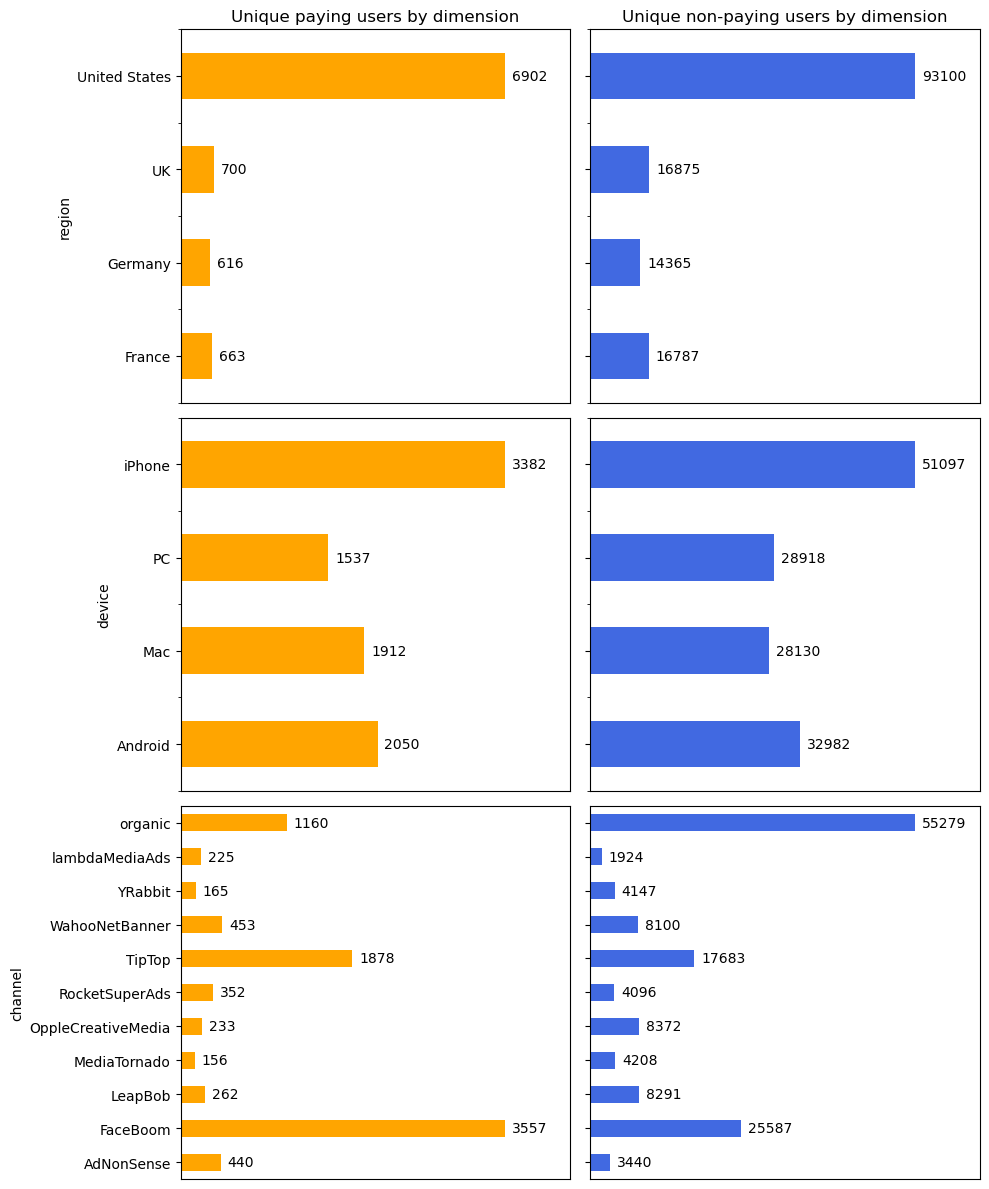

In [67]:
fun_plot_profiles(df_profiles, ['region', 'device', 'channel']);

Первые интересные наблюдения: США явно лидирует как источник платящих и неплатящих пользователей для нашего приложения. Остальные три страны - Великобритания, Германия и Франция приносят более-менее одинаковое количество пользователей. Распределение между странами похоже для обоих типов клиентов.

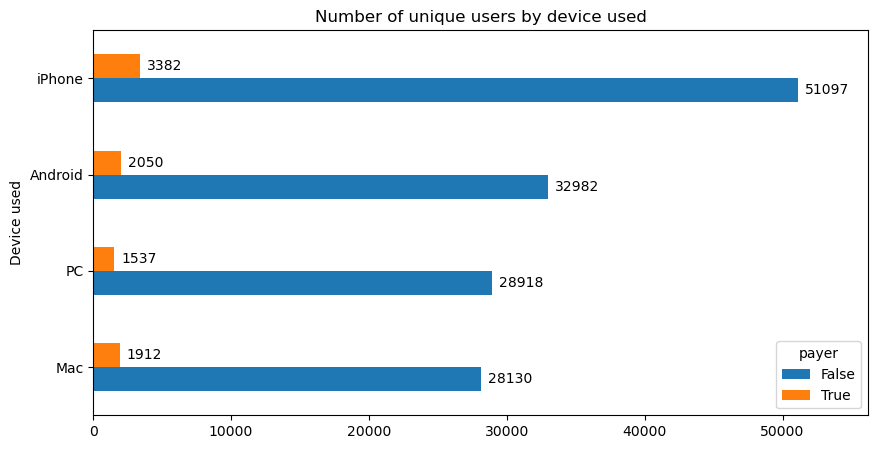

In [62]:
ax = pd.pivot_table(df_profiles,
                    index='device',
                    values='user_id',
                    columns='payer',
                    aggfunc='count') \
       .sort_values(by=False) \
       .plot(kind='barh',
             title='Number of unique users by device used',
             xlabel='Device used',
             ylabel='Unique users',
             figsize=FIGSIZE);
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5);
ax.margins(x=0.1)

Ситуация не такая драматичная, как со странами, но все равно есть на что посмотреть. Во-первых, есть девайс-лидер - это iPhone для обоих типов пользователей. Во-вторых, распределения разных типов пользователей по девайсам снова похожи.

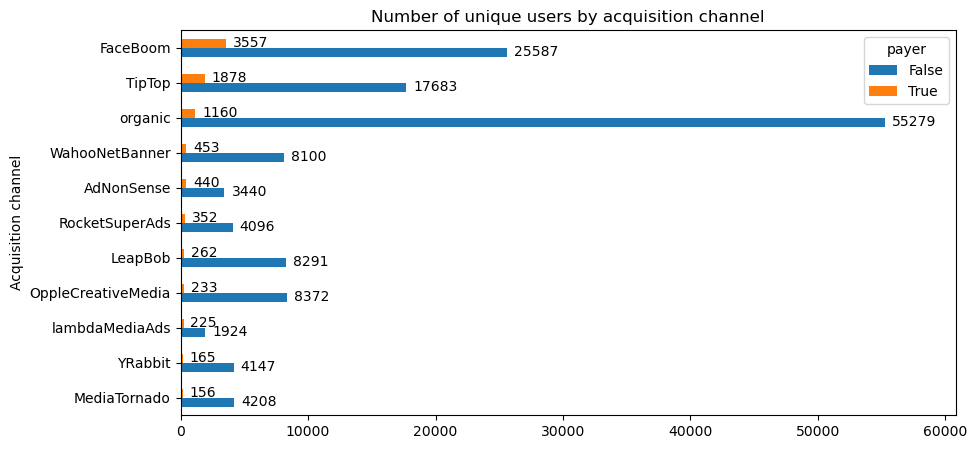

In [63]:
ax = pd.pivot_table(df_profiles,
                    index='channel',
                    values='user_id',
                    columns='payer',
                    aggfunc='count') \
       .sort_values(by=True) \
       .plot(kind='barh',
             title='Number of unique users by acquisition channel',
             xlabel='Acquisition channel',
             ylabel='Unique users',
             figsize=FIGSIZE);
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5);
ax.margins(x=0.1)

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

### Проанализируйте окупаемость рекламы с разбивкой по странам

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.